In [ ]:
%%capture
!unzip faces.zip
%cd Search_for_key_points_on_the_face

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
from collections import Counter


In [ ]:
y = pd.read_csv('train.csv', index_col=0)
y.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,
05317.jpg,25,55,63,39,145,36,171,45,39,74,61,69,79,72,130,68,145,65,159,65,113,103,79,148,113,148,143,141
04767.jpg,17,32,39,27,56,22,81,16,20,39,32,39,43,41,66,33,73,29,86,28,56,66,45,80,59,80,74,76
05241.jpg,33,44,70,44,119,41,142,41,33,71,50,66,69,66,127,58,139,56,144,56,94,101,74,135,89,135,112,133
03849.jpg,96,157,222,143,389,129,517,125,153,210,203,198,249,210,380,196,425,181,467,188,328,339,241,451,335,453,419,441
00952.jpg,13,19,30,16,51,17,66,16,18,25,24,25,29,25,48,26,55,24,59,23,39,43,31,56,41,56,49,55


In [ ]:
Y.isnull().sum()  # check data for missing values

x1     0
y1     0
x2     0
y2     0
x3     0
y3     0
x4     0
y4     0
x5     0
y5     0
x6     0
y6     0
x7     0
y7     0
x8     0
y8     0
x9     0
y9     0
x10    0
y10    0
x11    0
y11    0
x12    0
y12    0
x13    0
y13    0
x14    0
y14    0
dtype: int64

In [ ]:
X = []  # excract all images in grayscale 
for _file in os.listdir('train'):
  img = cv2.imread(os.path.join('train', _file), cv2.IMREAD_GRAYSCALE)
  im_shape = img.shape[0]
  img = cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_AREA)
  X.append( (_file, img, im_shape))
#X = np.array(X)


In [ ]:
Xy = pd.merge(pd.DataFrame(X, columns=['filename', 'img', 'shape']), y, on='filename', how='left').set_index('filename')  # join x and y data to make indexes consistend and also rescale data
Xy.iloc[:, 2:] = Xy.iloc[:, 2:].div(Xy['shape'], axis=0) * 96
Xy.head()

X_ = Xy.loc[:, 'img']
y_scaled = Xy.drop(columns=['img', 'shape'])


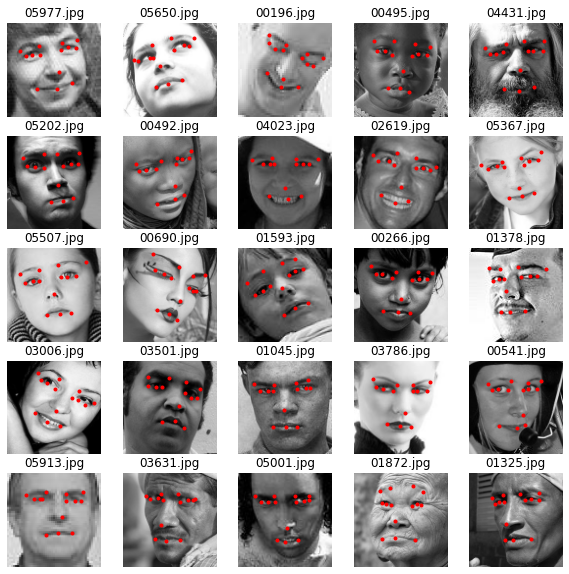

In [ ]:
def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    index = np.random.choice(len(X_), size=(nrows*ncols), replace=False)
    r_images = np.take(X_, index)  #
    r_names = np.take(X_.index, index)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for img, indx, ax in zip(r_images, r_names, axes.ravel()):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        xy = y_scaled.loc[indx].values.reshape(-1,2)
        ax.plot(xy[:, 0], xy[:, 1], 'ro', ms=3)
        ax.axis('off')
        ax.set_title(indx)

plot_faces()  # plot some images

In [ ]:
X_full = np.array([x.astype(np.float)[:,:, np.newaxis] for x in X_])
X_full.shape, X_full.dtype

((5000, 96, 96, 1), dtype('float64'))

In [ ]:
y_scaled.shape, y_scaled.values.dtype

((5000, 28), dtype('float64'))

In [ ]:
X_full = X_full / 255

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_full = output_pipe.fit_transform(y_scaled)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.33, random_state=420)

In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten

In [ ]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(96*96,)))
model.add(Activation('relu'))
model.add(Dense(28))

In [ ]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 200
history = model.fit(X_full.reshape(y_full.shape[0], -1), y_full, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 2s 516us/step - loss: 0.0359 - accuracy: 0.2035 - val_loss: 0.0278 - val_accuracy: 0.2710
Epoch 2/200
4000/4000 [==============================] - 2s 504us/step - loss: 0.0232 - accuracy: 0.2707 - val_loss: 0.0245 - val_accuracy: 0.2620
Epoch 3/200
4000/4000 [==============================] - 2s 490us/step - loss: 0.0199 - accuracy: 0.3047 - val_loss: 0.0224 - val_accuracy: 0.2820
Epoch 4/200
4000/4000 [==============================] - 2s 504us/step - loss: 0.0181 - accuracy: 0.3330 - val_loss: 0.0214 - val_accuracy: 0.3360
Epoch 5/200
4000/4000 [==============================] - 2s 507us/step - loss: 0.0171 - accuracy: 0.3543 - val_loss: 0.0211 - val_accuracy: 0.3250
Epoch 6/200
4000/4000 [==============================] - 2s 500us/step - loss: 0.0164 - accuracy: 0.3487 - val_loss: 0.0204 - val_accuracy: 0.2920
Epoch 7/200
4000/4000 [==============================] - 2s 514us/step

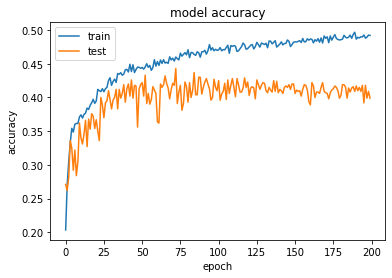

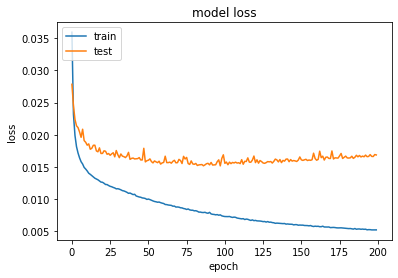

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

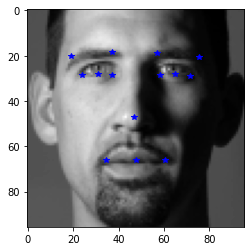

In [ ]:
i = 20
img = X_full[i, :, :, :].reshape(1, -1)
predictions = model.predict(img)

xy_predictions = output_pipe.inverse_transform(predictions).reshape(14, 2)


plt.imshow(X_full[i, :, :, 0], cmap='gray')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')

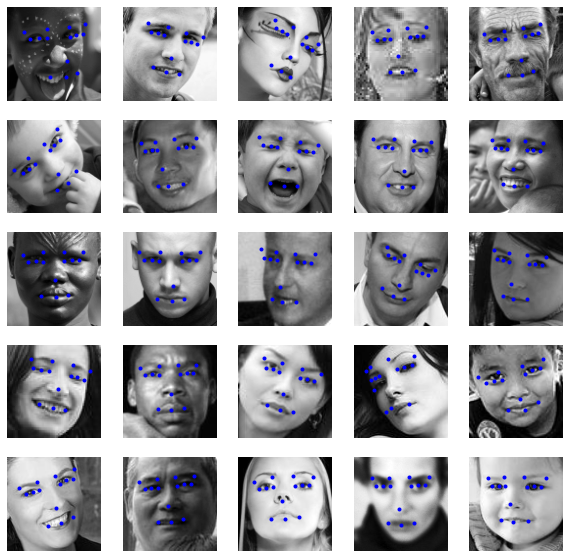

In [ ]:
def plot_faces_with_keypoints_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X_full.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_full[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(14, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'bo', ms=3)
        ax.axis('off')

plot_faces_with_keypoints_and_predictions(model)


In [ ]:
from keras.layers import Dropout, Flatten


In [ ]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(90, activation="relu"))
# layer 8
model.add(Dense(28))

In [ ]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 50
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 2680 samples, validate on 670 samples
Epoch 1/50
2680/2680 [==============================] - 49s 18ms/step - loss: 0.0260 - accuracy: 0.2731 - val_loss: 0.0224 - val_accuracy: 0.3343
Epoch 2/50
2680/2680 [==============================] - 48s 18ms/step - loss: 0.0205 - accuracy: 0.3216 - val_loss: 0.0225 - val_accuracy: 0.3343
Epoch 3/50
2680/2680 [==============================] - 48s 18ms/step - loss: 0.0205 - accuracy: 0.3056 - val_loss: 0.0229 - val_accuracy: 0.3343
Epoch 4/50
2680/2680 [==============================] - 49s 18ms/step - loss: 0.0205 - accuracy: 0.3388 - val_loss: 0.0224 - val_accuracy: 0.3343
Epoch 5/50
2680/2680 [==============================] - 48s 18ms/step - loss: 0.0204 - accuracy: 0.3388 - val_loss: 0.0225 - val_accuracy: 0.3343
Epoch 6/50
2680/2680 [==============================] - 48s 18ms/step - loss: 0.0204 - accuracy: 0.3373 - val_loss: 0.0234 - val_accuracy: 0.1701
Epoch 7/50
2680/2680 [==============================] - 48s 18ms/step - loss:

In [ ]:
model.save('model.h5')

In [ ]:
https://towardsdatascience.com/facial-keypoint-detection-detect-relevant-features-of-face-in-a-go-using-cnn-your-own-dataset-e09cf359c2bc
https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/
https://medium.com/nanonets/nanonets-how-to-use-deep-learning-when-you-have-limited-data-f68c0b512cab
http://iip.ict.ac.cn/sites/default/files/publication/3-2017FGFECCNN.pdf
http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/